## Generate dataset

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

Global variables

In [2]:
wavelengths     = np.arange(400, 800)*u.nm
FWHM            = 0.5
lambda_Na       = 589.0*u.nm
lambda_Mg       = 518.3*u.nm
width           = 1000
height          = 1500

Define the function to generate the image. 

In [3]:
def add_background(image_3d):
    '''
    '''
    # TODO: mutate the background
    for i in range(400):
        image_3d[:,:,i] += int(30-0.06*i)
    return image_3d

def add_stars(image_3d, coord_stars, amp_stars, T_stars): 
    '''
    '''
    # psf
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    # draw N stars with radius FWHM/2
    for [x, y], amp_star, T_star in zip(coord_stars, amp_stars, T_stars): 
        # spectrum
        BB = models.BlackBody(temperature=T_star)
        # add star to the image
        radius = int(5*FWHM)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*BB(wavelengths).value*amp_star
        star = star.astype('uint16')
        image_3d[x-radius:x+radius+1,y-radius:y+radius+1,:] += star
    return image_3d

def add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, dir_meteor, length_meteor): 
    '''
    '''
    # spectrum - continuous spectrum
    BB = models.BlackBody(temperature=T_meteor)
    meteor_x = BB(wavelengths).value*amp_meteor
    # spectrum - emission line
    amp_Na = amp_meteor*2e-6
    amp_Mg = amp_meteor*1e-6
    emission_Na = functional_models.Gaussian1D(mean=lambda_Na.value, stddev=FWHM)
    emission_Mg = functional_models.Gaussian1D(mean=lambda_Mg.value, stddev=FWHM)
    meteor_x += emission_Na(wavelengths.value)*amp_Na
    meteor_x += emission_Mg(wavelengths.value)*amp_Mg
    # trajectory
    meteor_y = np.arange(length_meteor)
    amplitude = 1e3
    # TODO: use true trajectory
    meteor_y = (meteor_y*10/length_meteor)**(0.1) - meteor_y/length_meteor
    meteor_y = meteor_y*amplitude
    meteor = np.outer(meteor_y, meteor_x)
    # draw meteor
    dx = np.cos(dir_meteor)
    dy = np.sin(dir_meteor)
    PSF = functional_models.Gaussian2D(x_stddev=FWHM, y_stddev=FWHM)
    for i in range(length_meteor): 
        radius = int(5*FWHM)
        x_plot = int(coord_meteor[0] + dx*i)
        y_plot = int(coord_meteor[1] + dy*i)
        xx = np.arange(-radius, radius+1)
        yy = np.arange(-radius, radius+1)
        XX, YY = np.meshgrid(xx, yy)
        star = np.repeat(PSF(XX, YY)[:,:,np.newaxis], 400, axis=2)*meteor[i, :]
        star = star.astype('uint16')
        image_3d[x_plot-radius:x_plot+radius+1,y_plot-radius:y_plot+radius+1,:] += star
    # plt.imshow(meteor)
    # plt.colorbar()
    # plt.show()


    # TODO: return the bounding box
    return image_3d

def add_landscape(image_3d): 
    '''
    TODO
    '''
    return image_3d

def capture(image_3d, direction, length): 
    '''
    '''
    dx = np.cos(direction)
    dy = np.sin(direction)
    for i in range(400): 
        # print(i, int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=0, shift=int(dx*length*i/400))
        image_3d[:,:,i] = np.roll(image_3d[:,:,i], axis=1, shift=int(dy*length*i/400))
    image_rgb = np.zeros([width, height, 3], dtype=np.uint16)
    # RGB filter
    # TODO: adjust the RGB curve of camera
    # TODO: adjust the true slit distortion
    gaussian_r = functional_models.Gaussian1D(mean=600, stddev=30)
    gaussian_g = functional_models.Gaussian1D(mean=540, stddev=30)
    gaussian_b = functional_models.Gaussian1D(mean=480, stddev=30)
    filter_r = gaussian_r(wavelengths.value)
    filter_g = gaussian_g(wavelengths.value)
    filter_b = gaussian_b(wavelengths.value)
    filter_r[200:400] = 1-np.arange(200)**2/200**2
    # generate RGB components
    image_rgb[:, :, 0] = np.average(image_3d*filter_r, axis=2)
    image_rgb[:, :, 1] = np.average(image_3d*filter_g, axis=2)
    image_rgb[:, :, 2] = np.average(image_3d*filter_b, axis=2)
    image_rgb = image_rgb.astype('uint16')
    return image_rgb

def augmentation(image_rgb): 
    '''
    Add the lens effect such as disortion and gaussian noise
    TODO: use `imgaug`
    '''
    return image_rgb


def generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                    angle_meteor, length_meteor, angle_slit, length_slit): 
    '''
    function to generate the image. 
    Args: 
        The position of all the stars, the meteor, etc.: 
        coords_stars    [N, 2]      the coordinates of stars plotted in the diagram. Will also give the number of stars
        TODO...
        angle_slit      [0, 2pi)
        angle_meteor    [0, 2pi)
        length_meteor   int         how long the meteor is 
        length_slit     int         how long the track of spectrum is
    Return: 
        one RGB image
    '''
    image_3d = np.zeros([width, height, 400], dtype=np.uint16)           # 0-65536, valid in 0-256 TODO: change to float16? 
    image_3d = add_background(image_3d)
    image_3d = add_stars(image_3d, coord_stars, amp_stars, T_stars)
    image_3d = add_meteor(image_3d, coord_meteor, amp_meteor, T_meteor, angle_meteor, length_meteor)
    image_rgb = capture(image_3d, angle_slit, length_slit)
    image_rgb = augmentation(image_rgb)
    # clip the image
    image_rgb = np.clip(image_rgb, 0, 255)# including 0 and 255
    # image_rgb = image_rgb.astype('uint8')
    return image_rgb #image_3d[:,:,0]
    



Generate the dataset. 

In [17]:
def generate_dataset(num_images, dir='./dataset/'): 
    '''
    generate the image and save the images in the directory. 
    Args: 
        num_images  
        dir
    Output: 
        JPG files and a json file in COCO format in the directory
    No return
    NOTE: returns an image for testing
    '''
    # TODO: check if the directory is usable
    # customized variables applying to all images
    annotation_id = 1
    labels = {
        'info': {
            'description': 'Meteor spectrum fake data',
            'url': 'https://cheysen.fit',
            'version': '0.1',
            'year': 2023,
            'contributor': 'Yichen Liu',
            'date_created': '2023/02/08'
        },
        'licenses': {
            'url': 'NaN',
            'id': 1,
            'name': 'NaN'
        },
        'images': [],
        'annotations': [],
        'categories': [{
                'id': 1,
                'name': 'meteor',
                'keypoints': [
                    'start_Na',
                    'end_Na',
                    'start_Mg',
                    'end_Mg',
                ],
                'skeleton': [
                    [1, 2],
                    [3, 4],
                ]
            },{
                'id': 2,
                'name': 'star',
                'keypoints': [
                    'start_star',
                    'end_star',
                    'start_', 
                    'end_'
                ],
                'skeleton': [
                    [1, 2],
                ]
            }
        ]
    }
    for image_id in range(1, num_images+1): 
        print('generating image %d...'%image_id)
        # parameters
        num_stars       = 200
        x_stars         = (np.random.rand(num_stars)*(width-10*FWHM)+5*FWHM).astype(np.int16)
        y_stars         = (np.random.rand(num_stars)*(height-10*FWHM)+5*FWHM).astype(np.int16)
        # TODO: change the border where the meteor can show
        length_meteor   = int(np.random.rand()*500)                      # pixel
        x_meteor        = int(np.random.rand()*(width-2*length_meteor)+length_meteor)
        y_meteor        = int(np.random.rand()*(height-2*length_meteor)+length_meteor)
        # image - parameters needed for `generate_image` function
        coord_stars     = np.array([x_stars, y_stars]).T            # [N, 2]pixel
        amp_stars       = np.random.rand(num_stars)*1e8             # [N]erg -> pixel value
        T_stars         = (np.random.rand(num_stars)*15000+5000)*u.K# [N]5000K-20000K
        coord_meteor    = [x_meteor, y_meteor]
        amp_meteor      = np.random.rand()*1e8
        T_meteor        = 2000*u.K
        angle_meteor    = np.random.rand()*2*np.pi                  # radian
        # length_meteor   = int(np.random.rand()*500)                 # pixel
        angle_slit      = np.random.rand()*2*np.pi                  # radian
        length_slit     = 100
        # image
        image = generate_image(coord_stars, amp_stars, T_stars, coord_meteor, amp_meteor, T_meteor, 
                                angle_meteor, length_meteor, angle_slit, length_slit)
        image8 = image.astype(np.uint8)-1
        im = Image.fromarray(image8)
        im.save(os.path.join(dir, '%d.jpg'%image_id), quality=100)
        # label - image
        label_image = {
            'license': 1,
            'file_name': '%d.jpg'%image_id,
            'height': height,
            'width': width,
            'id': image_id
        }
        labels['images'].append(label_image)
        # label - annotation - meteor
        bbox_x1      = int(min(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y1      = int(min(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_x2      = int(max(
            x_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit, 
            x_meteor + np.cos(angle_meteor)*length_meteor, 
            x_meteor + np.cos(angle_slit)*length_slit + np.cos(angle_meteor)*length_meteor, 
        ))
        bbox_y2      = int(max(
            y_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit, 
            y_meteor + np.sin(angle_meteor)*length_meteor, 
            y_meteor + np.sin(angle_slit)*length_slit + np.sin(angle_meteor)*length_meteor, 
        ))
        bbox_w      = bbox_x2 - bbox_x1
        bbox_h      = bbox_y2 - bbox_y1
        start_Na_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        start_Na_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Na.value-400)/400)
        end_Na_x    = int(start_Na_x + np.cos(angle_meteor)*length_meteor)
        end_Na_y    = int(start_Na_y + np.sin(angle_meteor)*length_meteor)
        start_Mg_x  = int(x_meteor + np.cos(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        start_Mg_y  = int(y_meteor + np.sin(angle_slit)*length_slit*(lambda_Mg.value-400)/400)
        end_Mg_x    = int(start_Mg_x + np.cos(angle_meteor)*length_meteor)
        end_Mg_y    = int(start_Mg_y + np.sin(angle_meteor)*length_meteor)
        label_meteor = {
            'id': annotation_id, 
            'image_id': image_id,
            'category_id': 1,
            'bbox': [
                bbox_y1, bbox_x1, bbox_h, bbox_w
            ],
            'keypoints': [
                start_Na_y, start_Na_x, 2, end_Na_y, end_Na_x, 2, 
                start_Mg_y, start_Mg_x, 2, end_Mg_y, end_Mg_x, 2
            ], 
            'num_keypoints': 4
        }
        labels['annotations'].append(label_meteor)
        annotation_id += 1
        # label - annotation - stars
        for x, y in coord_stars: 
            start_star_x    = x
            start_star_y    = y
            end_star_x      = int(x + np.cos(angle_slit)*length_slit)
            end_star_y      = int(y + np.sin(angle_slit)*length_slit)
            bbox_x1 = min(start_star_x, end_star_x)
            bbox_y1 = min(start_star_y, end_star_y)
            bbox_x2 = max(start_star_x, end_star_x)
            bbox_y2 = max(start_star_y, end_star_y)
            bbox_w      = bbox_x2 - bbox_x1
            bbox_h      = bbox_y2 - bbox_y1
            # check if the star is valid for labelling
            if 0<=end_star_x and end_star_x<width and 0<=end_star_y and end_star_y<height: 
                label_star = {
                    'id': annotation_id, 
                    'image_id': image_id,
                    'category_id': 2,
                    'bbox': [
                        bbox_y1, bbox_x1, bbox_h, bbox_w
                    ],
                    'keypoints': [
                        start_star_y, start_star_x, 2, end_star_y, end_star_x, 2, 0, 0, 0, 0, 0, 0
                    ], 
                    'num_keypoints': 2
                }
                labels['annotations'].append(label_star)
                annotation_id += 1
    # save json file
    with open(os.path.join(dir, 'labels.json'), 'w') as f:
        json.dump(labels, f, sort_keys=False, indent=2, separators=(',', ': '), cls=NumpyEncoder)
    
    return image, labels

dir='./dataset/'
num_images = 100
image, labels = generate_dataset(num_images, dir)

plt.figure(figsize=[15, 10])
plt.imshow(image)

generating image 1...


## Register the data

Try to read the dataset we have just generated and confirm that the data is correctly loaded and labelled 

In [5]:
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.modeling import models
from astropy.modeling import functional_models
from astropy import units as u
import os, json, random, cv2
from PIL import Image
from numpyencoder import NumpyEncoder

dir='./dataset/'

register_coco_instances('fake_meteors', {}, os.path.join(dir, 'labels.json'), dir)

(1000, 1500, 3)
(1000, 1500, 3)


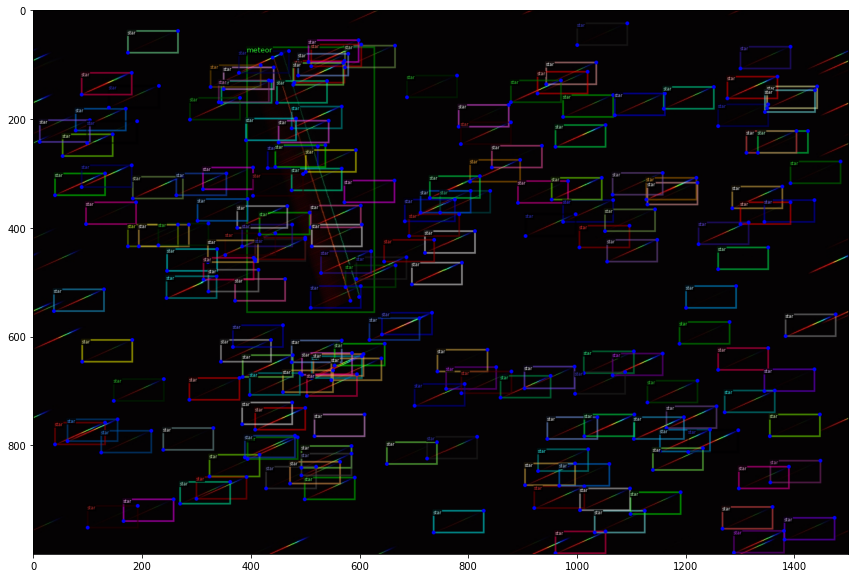

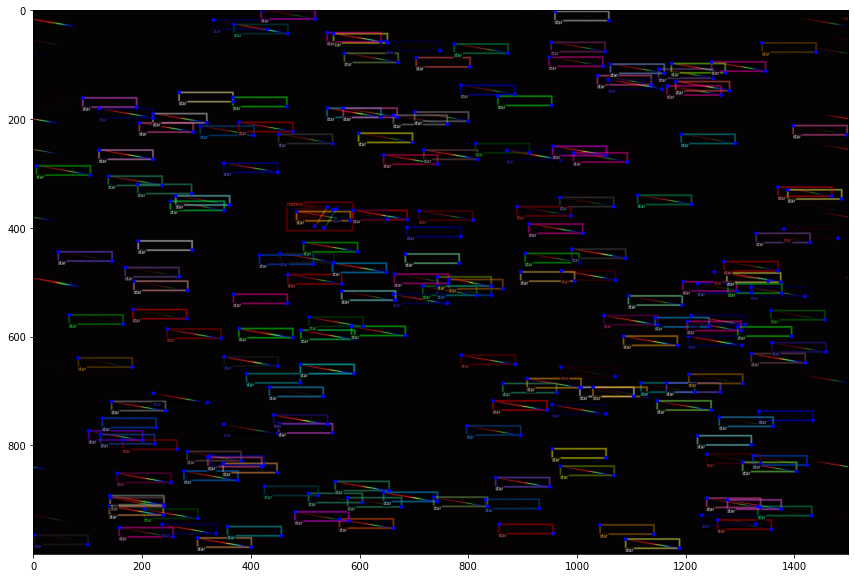

In [15]:

dataset_dicts = DatasetCatalog.get('fake_meteors')
metadata = MetadataCatalog.get('fake_meteors')

for d in random.sample(dataset_dicts, 1):
    img = plt.imread(d["file_name"])
    print(img.shape)
    visualizer = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=[15, 10])
    plt.imshow(out.get_image()[:, :, ::-1])


## Train

In [7]:
a = np.array([1, 2])
a.reshape(-1, 2)

array([[1, 2]])

In [8]:

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(data[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(out.get_image()[:, :, ::-1])

NameError: name 'data' is not defined

In [ ]:
im ={
      'license': 4,
      'file_name': '%d.jpg'%width,
      'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
      'height': height,
      'width': width,
      'date_captured': '2013-11-14 17:02:52',
      'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
      'id': 397133
    }
labels['images'].append(im)
labels

{'info': {'description': 'Meteor spectrum fake data',
  'url': 'https://cheysen.fit',
  'version': '0.1',
  'year': 2023,
  'contributor': 'Yichen Liu',
  'date_created': '2023/02/08'},
 'licenses': {'url': 'NaN', 'id': 1, 'name': 'NaN'},
 'images': [{'license': 4,
   'file_name': '000000397133.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
   'height': 427,
   'width': 640,
   'date_captured': '2013-11-14 17:02:52',
   'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
   'id': 397133},
  {'license': 4,
   'file_name': '000000397133.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
   'height': 427,
   'width': 640,
   'date_captured': '2013-11-14 17:02:52',
   'flickr_url': 'http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg',
   'id': 397133},
  {'license': 4,
   'file_name': '000000397133.jpg',
   'coco_url': 'http://images.cocodataset.org/val2017/000000397133.jpg',
   'height': 15

In [ ]:

with open(os.path.join(dir, 'labels.json'), 'w') as f:
    json.dump(labels, f, sort_keys=True, indent=2, separators=(',', ': '))